In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

## common libraries, variables and methods 

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
from torch.distributions import Categorical
import gym
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import re

In [ ]:
DQN_PATH = "/content/drive/MyDrive/IITM/collab/cs6700/pa2/dqn"
AC_PATH = "/content/drive/MyDrive/IITM/collab/cs6700/pa2/ac"

AVG_RWD_PATTERN = re.compile(r'(.*)_(rwd|avgrwd)$')
AVG_STEP_PATTERN = re.compile(r'(.*)_(step|avgstep)$')

VAR_RWD_PATTERN = re.compile(r'(.*)_varrwd$')
VAR_STEP_PATTERN = re.compile(r'(.*)_varstep$')

In [ ]:
def read_file(filepath):
  data = []
  with open(filepath, 'r') as fp:
    for line in fp:
      line = line.strip()
      if line:
        data.append(float(line))
  return data

## DQN

In [ ]:

# Environment Variables
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):
  def __init__(self, input, output, layers=[]):
    super(QNetwork, self).__init__()
    self.hidden = nn.ModuleList()
    in_layer = input
    for out_layer in layers:
      self.hidden.append(nn.Linear(in_layer, out_layer))
      in_layer = out_layer
    self.out = nn.Linear(in_layer, output)

  def forward(self, x):
    for fc in self.hidden:
      x = F.relu(fc(x))
    return self.out(x)


class ReplayBuffer(object):
  def __init__(self, buffer_size):
    self.memory = deque(maxlen=buffer_size)
    self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

  def __len__(self):
    return len(self.memory)

  def add(self, state, action, reward, next_state, done):
    e = self.experience(state, action, reward, next_state, done)
    self.memory.append(e)
  
  def sample(self, batch_size):
    # experiences = np.random.choice(self.memory, batch_size, replace=False)
    experiences = random.sample(self.memory, k=batch_size)
    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(DEVICE)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(DEVICE)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(DEVICE)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(DEVICE)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(DEVICE)
    return (states, actions, rewards, next_states, dones)


class DQN_Agent(object):
  def __init__(self, state_size, action_size, layers=[],
               gamma=0.9, lr=0.001, buffer_size=1e3,
               batch_size=64, update_target=20, truncation_limit=1):
    self.q_local = QNetwork(state_size, action_size, layers).to(DEVICE)
    self.q_target = QNetwork(state_size, action_size, layers).to(DEVICE)
    self.optimizer = optim.Adam(self.q_local.parameters(), lr=lr)
    self.memory = ReplayBuffer(buffer_size)
    self.gamma = gamma
    self.batch_size = batch_size
    self.update_target = update_target
    self.truncation_limit = truncation_limit
    self.t = 0

  def ep_greedy(self, values, ep):
    if np.random.rand() > ep:
      action = np.argmax(values)
    else:
      action = np.random.randint(len(values))
    return action

  def softmax(self, values, beta):
    values /= beta
    prob = np.exp(values - np.max(values))
    prob /= np.sum(prob)
    return np.random.choice(len(values), p=prob)

  def get_action(self, state, explore=0.0):
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    self.q_local.eval()
    with torch.no_grad():
        action_values = self.q_local(state)
    self.q_local.train()
    qvalues = action_values.cpu().data.numpy()[0]
    # return self.ep_greedy(qvalues, explore)
    return self.softmax(qvalues, explore)

  def update(self, state, action, reward, next_state, done):
    self.memory.add(state, action, reward, next_state, done)
    if len(self.memory) >= self.batch_size:
      exps = self.memory.sample(self.batch_size)
      self.train(exps)
    self.t = (self.t + 1) % self.update_target
    if self.t == 0:
      self.q_target.load_state_dict(self.q_local.state_dict())

  def train(self, exps):
    states, actions, rewards, next_states, dones = exps
    q_targets_next = self.q_target(next_states).detach().max(1)[0].unsqueeze(1)
    targets = rewards + (self.gamma * q_targets_next * (1 - dones))
    expected = self.q_local(states).gather(1, actions)
    loss = F.mse_loss(targets, expected)
    self.optimizer.zero_grad()
    loss.backward()
    for param in self.q_local.parameters():
      param.grad.data.clamp_(-self.truncation_limit, self.truncation_limit)
    self.optimizer.step()


class DQN_Runner(object):
  def __init__(self, params):
    self.params = params

    self.env = gym.make(params['environment'])
    self.truncation_rwd = params["truncation_rwd"]
    self.explore_start = params['explore_start']
    self.explore_end = params['explore_end']
    self.decay = params['decay'] if 'decay' in params else 0.995    
    self.runs = params['runs']
    self.episodes = params['episodes']
    self.max_t = params['max_t']
    self.save_path = params['save_path']
    self.name = f"ly_{params['layers']}_g_{params['gamma']}_lr_{params['lr']}_"+\
                f"buf_{params['buffer_size']}_bat_{params['batch_size']}_"+\
                f"ut_{params['update_target']}_tlmt_{params['truncation_limit']}_"+\
                f"exe_{params['explore_end']}_d_{params['decay']}"

  def reset(self):
    params = self.params
    self.env.reset()
    state_size, action_size = self.env.observation_space.shape[0], self.env.action_space.n
    self.agent = DQN_Agent(state_size=state_size,
                           action_size=action_size,
                           layers=params["layers"],
                           gamma=params['gamma'],
                           lr=params['lr'],
                           buffer_size=params['buffer_size'],
                           batch_size=params['batch_size'],
                           update_target=params['update_target'],
                           truncation_limit=params['truncation_limit'])

  def single_run(self, print_after=100):
    self.reset() # reset the agent at each new run
    explore = self.explore_start
    episodes_reward, episodes_step = [], []
    reward_window = deque(maxlen=100) 
    for episode in range(1, self.episodes+1):
      state = self.env.reset()
      total_rwd, done = 0, False
      step = 0
      while (not done) and (step < self.max_t):
        action = self.agent.get_action(state, explore)
        next_state, rwd, done, _ = self.env.step(action)
        self.agent.update(state, action, rwd, next_state, done)
        state = next_state
        total_rwd += rwd
        step += 1
      episodes_reward.append(total_rwd)
      episodes_step.append(step)
      reward_window.append(total_rwd)
      explore = max(self.explore_end, explore*self.decay)
      if (episode % print_after) == 0:
        print(f"Episode: {episode}\tAverage Reward: {np.mean(reward_window)}")
      if np.mean(reward_window) > self.truncation_rwd:
        print(f"Environment solved in {episode} episodes!\tAverage Reward: {np.mean(reward_window)}")
        break
    episodes_reward.extend([total_rwd]*(self.episodes - episode))
    episodes_step.extend([step]*(self.episodes - episode))
    return episodes_reward, episodes_step

  def avg_run(self):
    avg_rwd_list = np.zeros(self.episodes)
    avg_step_list = np.zeros(self.episodes)
    for run in range(self.runs):
      rwd_list, step_list = self.single_run()
      rwd_list, step_list = np.array(rwd_list), np.array(step_list)
      avg_rwd_list += (rwd_list - avg_rwd_list) / (run+1)
      avg_step_list += (step_list - avg_step_list) / (run+1)
      print("-"*10)
    return avg_rwd_list, avg_step_list

  def save_and_plot(self):
    avg_rwd_list, avg_step_list = self.avg_run()
    self.save(avg_rwd_list, f"{self.name}_rwd")
    self.save(avg_step_list, f"{self.name}_step")
    self.plot(avg_rwd_list, "Reward")
    self.plot(avg_step_list, "Step")

  def save(self, save_list, name):
    path = os.path.join(self.save_path, self.env.spec.id)
    if not os.path.exists(path):
      os.makedirs(path)
    filename = os.path.join(path, name)
    with open(filename, 'w') as fp:
      for rwd in save_list:
        fp.write(f"{rwd}\n")

  def plot(self, data_list, name):
    plt.title(self.name)
    plt.ylabel(name)
    plt.xlabel("Episode")
    plt.plot(np.arange(len(data_list)), data_list)
    plt.show()



#### Hyper-parameter tuning

In [ ]:
params_dqn = {
    "environment": "CartPole-v1",
    "truncation_rwd": 195.0,
    # q network
    "layers": [64, 32], # matters
    "gamma": 0.99,
    "lr": 5e-4,  # matters
    "batch_size": 32,
    "truncation_limit": 1, # matters
    # replay buffer
    "buffer_size": int(1e5),
    "update_target": 20,  # matters
    # softmax
    "explore_start": 1.0, # matters
    "explore_end": 0.1,  # matters
    "decay": 0.9,   # matters
    # runs
    "runs": 10,
    "episodes": 500,
    "max_t": 1_000,
    # save path
    "save_path": "/content/drive/MyDrive/IITM/collab/cs6700/pa2/dqn_returaj"
}

dqn_runner = DQN_Runner(params_dqn)

dqn_runner.save_and_plot()

#### Plot generation

In [ ]:
def plot_dqn(env_name, dir_path):
  files = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]
  configs = []
  for f in files:
    p = AVG_RWD_PATTERN.search(f)
    if p:
      configs.append(p.group(1))
  
  configs_map = {}
  for c in configs:
    values = {
        "rwd": read_file(join(dir_path, f"{c}_rwd")),
        "step": read_file(join(dir_path, f"{c}_step"))
    }
    configs_map[c] = values

  plt.figure(1, figsize=(9, 7), dpi=80)
  plt.title(f"Avg Reward for {env_name}")
  plt.ylabel("Avg Reward")
  plt.xlabel("Episode")
  for k, v in configs_map.items():
    x = list(range(len(v['rwd'])))
    plt.plot(x, v['rwd'], label=k)
  plt.legend()
  plt.show()

  plt.figure(2, figsize=(9, 7), dpi=80)
  plt.title(f"Avg number of steps for {env_name}")
  plt.ylabel("Avg Step")
  plt.xlabel("Episode")
  for k, v in configs_map.items():
    x = list(range(len(v['step'])))
    plt.plot(x, v['step'], label=k)
  plt.legend()
  plt.show()

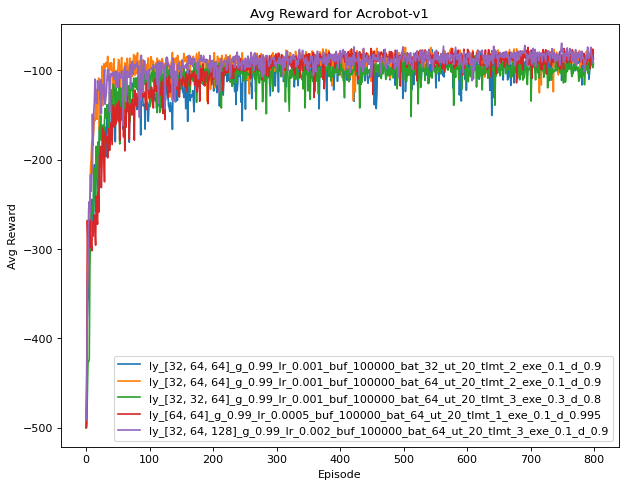

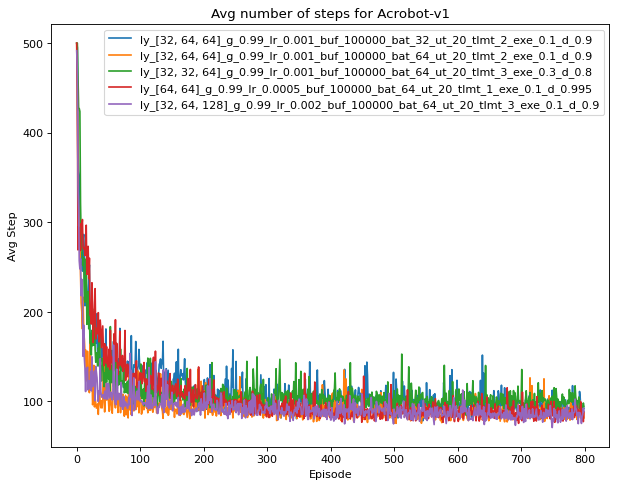

In [ ]:
env_name = "Acrobot-v1"

plot_dqn(env_name, join(DQN_PATH, env_name))

## Actor Critic

In [ ]:
# Environment Variables
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class ActorCriticNetwork(nn.Module):
  def __init__(self, input, output, layers=[]):
    super(ActorCriticNetwork, self).__init__()
    self.hidden = nn.ModuleList()
    in_layer = input
    for out_layer in layers:
      self.hidden.append(nn.Linear(in_layer, out_layer))
      in_layer = out_layer
    self.policy = nn.Linear(in_layer, output)
    self.value = nn.Linear(in_layer, 1)
    # self.dropout = nn.Dropout(0.4)  # use dropout

  def forward(self, x):
    for fc in self.hidden:
      x = F.relu(fc(x))
      # x = self.dropout(x)   # use dropout
    pi = F.softmax(self.policy(x), dim=-1)
    v = self.value(x)
    return pi, v


class AC_Agent(object):
  def __init__(self, state_size, action_size, layers=[], gamma=0.9, lr=0.01):
    self.ac_model = ActorCriticNetwork(state_size, action_size, layers)
    self.optimizer = optim.Adam(self.ac_model.parameters(), lr=lr)
    self.gamma = gamma

  def get_action(self, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    self.ac_model.eval()
    with torch.no_grad():
      pi, _ = self.ac_model(state)
    self.ac_model.train()
    # softmax
    prob = pi.cpu().data.numpy()[0]
    prob = np.nan_to_num(prob) + 1e-6
    prob /= np.sum(prob)
    return np.random.choice(len(prob), p=prob)
    # # Categorical
    # m = Categorical(pi)
    # action = m.sample()
    # return action.item()

  def actor_loss(self, action, pi, delta):
    action = torch.tensor([action], dtype=torch.long).unsqueeze(0).to(DEVICE)
    p = pi.gather(1, action)
    delta = delta.cpu().data.numpy()[0, 0]
    return -torch.log(p)*delta

  def critic_loss(self, delta):
    return delta**2

  def train(self, n, state, action, discnt_reward, nth_state, done):
    self.ac_model.eval()
    with torch.no_grad():
      nth_state = torch.from_numpy(nth_state).float().unsqueeze(0).to(DEVICE)
      _, v_next = self.ac_model(nth_state)
    self.ac_model.train()
    v_next = v_next.cpu().data.numpy()[0, 0]

    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    pi, v_s = self.ac_model(state)

    delta = (discnt_reward + (self.gamma**n)*v_next*(1 - done) - v_s)
    loss = self.actor_loss(action, pi, delta) + self.critic_loss(delta)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()


class AC_Runner(object):
  def __init__(self, params):
    self.params = params
    self.env = gym.make(params['environment'])
    self.gamma = params["gamma"]
    self.n = params['n']
    self.runs = params['runs']
    self.episodes = params['episodes']
    self.max_t = params['max_t']
    self.save_path = params['save_path']
    self.name = f"ly_{params['layers']}_lr_{params['lr']}_" +\
                f"eps_{params['episodes']}_n_{params['n']}"

  def reset(self):
    params = self.params
    self.env.reset()
    state_size, action_size = self.env.observation_space.shape[0], self.env.action_space.n
    self.agent = AC_Agent(state_size=state_size,
                          action_size=action_size,
                          layers=params["layers"],
                          gamma=params['gamma'],
                          lr=params['lr'])

  def single_run(self, print_after=100):
    self.reset() # reset the agent at each new run
    episodes_reward, episodes_step = [], []
    reward_window = deque(maxlen=100) 
    experiences = deque(maxlen=self.n)
    for episode in range(1, self.episodes+1):
      state = self.env.reset()
      total_rwd, done = 0, False
      step = 0
      assert not experiences
      while (not done) and (step < self.max_t):
        action = self.agent.get_action(state)
        next_state, rwd, done, _ = self.env.step(action)
        experiences.appendleft([state, action, 0])
        gamma = 1.0
        for e in experiences:
          e[2] += gamma*rwd
          gamma *= self.gamma
        if len(experiences) == self.n:
          e = experiences.pop()
          self.agent.train(self.n, e[0], e[1], e[2], next_state, done)
        state = next_state
        total_rwd += rwd
        step += 1
      while experiences:
        e = experiences.pop()
        self.agent.train(self.n, e[0], e[1], e[2], next_state, done)
      episodes_reward.append(total_rwd)
      episodes_step.append(step)
      reward_window.append(total_rwd)
      if (episode % print_after) == 0:
        print(f"Episode: {episode}\tAverage Reward: {np.mean(reward_window)}")
      if np.mean(reward_window) >= 195.0:
        print(f"Environment solved in {episode} episodes!\tAverage Reward: {np.mean(reward_window)}")
        break
    episodes_reward.extend([total_rwd]*(self.episodes - episode))
    episodes_step.extend([step]*(self.episodes - episode))
    return episodes_reward, episodes_step

  def multi_run(self):
    episode_rwds, episode_steps = [], []
    for run in range(self.runs):
      rwd_list, step_list = self.single_run()
      episode_rwds.append(rwd_list)
      episode_steps.append(step_list)
      print("--"*10)
    episode_rwds = np.array(episode_rwds)
    episode_steps = np.array(episode_steps)
    avg_rwd, var_rwd = episode_rwds.mean(axis=0), episode_rwds.var(axis=0)
    avg_step, var_step = episode_steps.mean(axis=0), episode_steps.var(axis=0)
    return avg_rwd, var_rwd, avg_step, var_step

  def save_and_plot(self):
    avg_rwd, var_rwd, avg_step, var_step = self.multi_run()
    self.save(avg_rwd, f"{self.name}_avgrwd")
    self.save(var_rwd, f"{self.name}_varrwd")
    self.save(avg_step, f"{self.name}_avgstep")
    self.save(var_step, f"{self.name}_varstep")
    self.plot(avg_rwd, "Avg Reward")
    self.plot(var_rwd, "Variance Reward")
    self.plot(avg_step, "Avg Step")
    self.plot(var_step, "Variance Step")

  def save(self, save_list, name):
    path = os.path.join(self.save_path, self.env.spec.id)
    if not os.path.exists(path):
      os.makedirs(path)
    filename = os.path.join(path, name)
    with open(filename, 'w') as fp:
      for rwd in save_list:
        fp.write(f"{rwd}\n")

  def plot(self, data_list, name):
    plt.title(self.name)
    plt.ylabel(name)
    plt.xlabel("Episode")
    plt.plot(np.arange(len(data_list)), data_list)
    plt.show()


#### Hyper-parameter tuning

In [ ]:
params_ac = {
    "environment": "Acrobot-v1",
    # policy/value network
    "layers": [32, 64, 64], # matters
    "gamma": 0.99,
    "n":50,
    "lr": 1e-2,  # matters 
    # runs
    "runs": 1,
    "episodes": 200,
    "max_t": 1_000,
    # save path
    "save_path": "/content/drive/MyDrive/IITM/collab/cs6700/pa2/ac_returaj"
}

ac_runner = AC_Runner(params_ac)
ac_runner.save_and_plot()

#### Plot Generation

In [ ]:
def plot_ac(env_name, dir_path):
  files = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]
  configs = []
  for f in files:
    p = AVG_RWD_PATTERN.search(f)
    if p:
      configs.append(p.group(1))
  
  configs_map = {}
  for c in configs:
    values = {
        "a_rwd": read_file(join(dir_path, f"{c}_avgrwd")),
        "v_rwd": read_file(join(dir_path, f"{c}_varrwd")),
        "a_step": read_file(join(dir_path, f"{c}_avgstep")),
        "v_step": read_file(join(dir_path, f"{c}_varstep"))
    }
    configs_map[c] = values

  plt.figure(1, figsize=(9, 7), dpi=80)
  plt.title(f"Avg Reward for {env_name}")
  plt.ylabel("Avg Reward")
  plt.xlabel("Episode")
  for k, v in configs_map.items():
    x = list(range(len(v['a_rwd'])))
    plt.plot(x, v['a_rwd'], label=k)
  plt.legend()
  plt.show()

  plt.figure(2, figsize=(9, 7), dpi=80)
  plt.title(f"Variance Reward for {env_name}")
  plt.ylabel("Var Reward")
  plt.xlabel("Episode")
  for k, v in configs_map.items():
    x = list(range(len(v['v_rwd'])))
    plt.plot(x, v['v_rwd'], label=k)
  plt.legend()
  plt.show()

  plt.figure(3, figsize=(9, 7), dpi=80)
  plt.title(f"Avg number of steps for {env_name}")
  plt.ylabel("Avg Step")
  plt.xlabel("Episode")
  for k, v in configs_map.items():
    x = list(range(len(v['a_step'])))
    plt.plot(x, v['a_step'], label=k)
  plt.legend()
  plt.show()

  plt.figure(4, figsize=(9, 7), dpi=80)
  plt.title(f"Variance Step for {env_name}")
  plt.ylabel("Var Step")
  plt.xlabel("Episode")
  for k, v in configs_map.items():
    x = list(range(len(v['v_step'])))
    plt.plot(x, v['v_step'], label=k)
  plt.legend()
  plt.show()

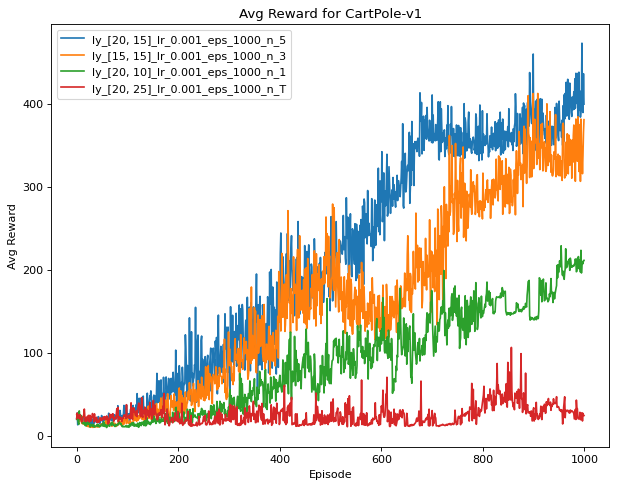

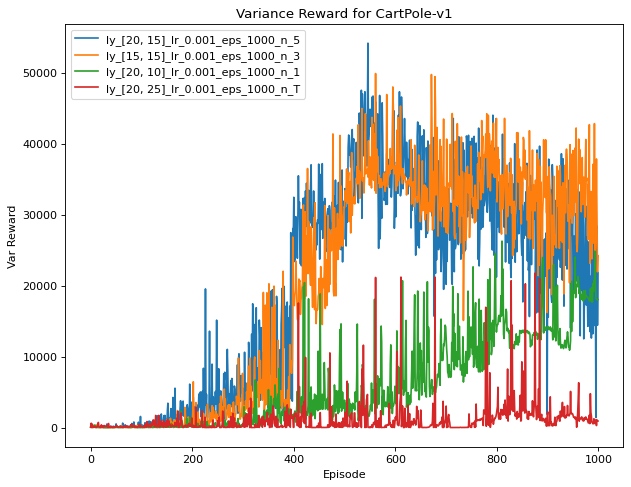

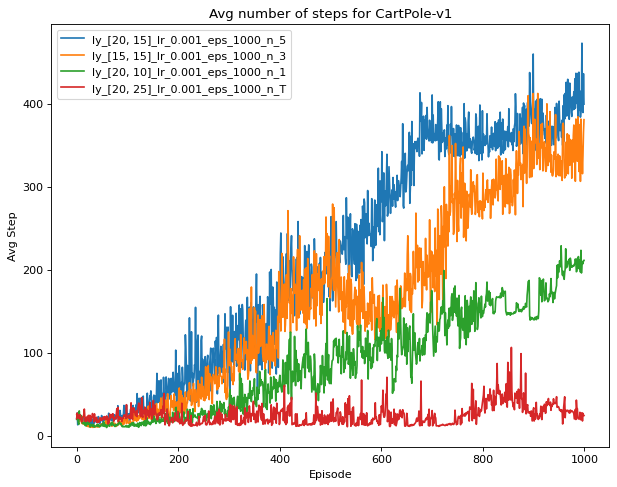

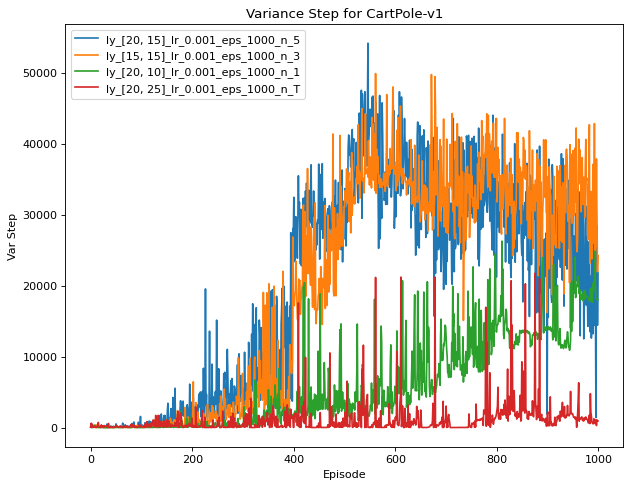

In [ ]:
env_name = "CartPole-v1"

plot_ac(env_name, join(AC_PATH, env_name))